In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from get_from_web import get_from_web

f2save = 'datasetfinalcorrected2.xlsx'
download_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fdeathsbyvaccinationstatusengland%2fdeathsoccurringbetween2januaryand24september2021/' + f2save

#GET file from web
if True:
    #def get_from_web(download_url, headers=None, num_recurr=1, f2save=None, n_attempts=2):
    ret_code, _ = get_from_web(download_url, f2save=f2save)
    print(ret_code)

In [113]:
#GET file from hdd
#Table4: Table 4: Weekly age-specific mortality rates by vaccination status for all deaths, per 100,000 people, England, deaths occurring between 2 January 2021 and 24 September 2021 1,2,3,4,5,6,7
df = pd.read_excel(f2save, sheet_name='Table 4', header=3)
df.dropna(subset=['Vaccination status'], inplace=True)
df.drop(columns=['Unnamed: 8'], inplace=True)
df['Week ending'] = pd.to_datetime(df['Week ending'])
df.set_index('Week ending', inplace=True)
df.head(5)

,Week number,Vaccination status,Age group,Number of deaths,Population,Percentage of total age-group population,"Age-specific rate per 100,000",Lower confidence limit,Upper confidence limit
Week ending,,,,,,,,,
2021-01-08,1.0,Unvaccinated,10-59,991.0,26822400.0,98.1,3.7,3.5,3.9
2021-01-08,1.0,Unvaccinated,60-69,1403.0,5138033.0,98.1,27.3,25.9,28.8
2021-01-08,1.0,Unvaccinated,70-79,2900.0,4153114.0,97.3,69.8,67.3,72.4
2021-01-08,1.0,Unvaccinated,80+,6974.0,1686889.0,67.0,413.4,403.8,423.2
2021-01-15,2.0,Unvaccinated,10-59,1064.0,26382353.0,96.5,4,3.8,4.3


In [106]:
mask_vacc = df['Vaccination status'] == 'Unvaccinated'
#unvaccinated
df_unvacc = df[mask_vacc].pivot(index='Week number', columns=['Age group'], values=['Number of deaths', 'Population'])
#Total population (unvaccinated + vaccinated)
df_unvacc['Number of deaths', 'total'] = df_unvacc['Number of deaths'].sum(axis=1)
df_unvacc['Population', 'total'] = df_unvacc['Population'].sum(axis=1)
df_mortality = 100000*df_unvacc['Number of deaths'].div(df_unvacc['Population'])
df_mortality.columns=pd.MultiIndex.from_product([['unvaccinated'], ['10-59', '60-69', '70-79', '80+', 'total']])

#vaccinated
#sum 'Number of deaths', 'Population' across all groups (Within 21 days of first dose, 21 days or more after first dose, Second dose)
df_vacc = pd.pivot_table(df[~mask_vacc], values=['Number of deaths', 'Population'], index='Week number', columns=['Age group'], aggfunc=np.sum)
#Total population (unvaccinated + vaccinated)
df_vacc['Number of deaths', 'total'] = df_vacc['Number of deaths'].sum(axis=1)
df_vacc['Population', 'total'] = df_vacc['Population'].sum(axis=1)
tmp = 100000*df_vacc['Number of deaths'].div(df_vacc['Population'])
tmp.columns=pd.MultiIndex.from_product([['vaccinated'], ['10-59', '60-69', '70-79', '80+', 'total']])

#join dataframes
df_mortality = df_mortality.join(tmp)

age_group: 10-59  mean_diff:0.82  mean_diff_last.half.year:0.49
age_group: 60-69  mean_diff:2.68  mean_diff_last.half.year:2.40
age_group: 70-79  mean_diff:3.09  mean_diff_last.half.year:2.16
age_group: 80+  mean_diff:3.17  mean_diff_last.half.year:1.67
age_group: total  mean_diff:0.29  mean_diff_last.half.year:0.22


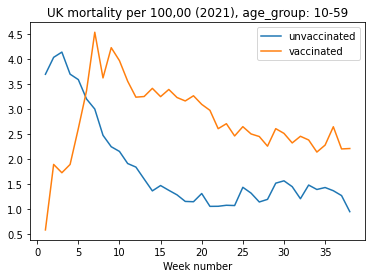

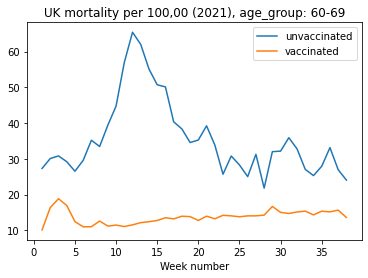

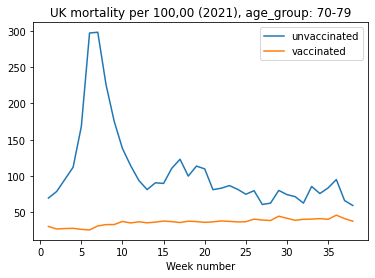

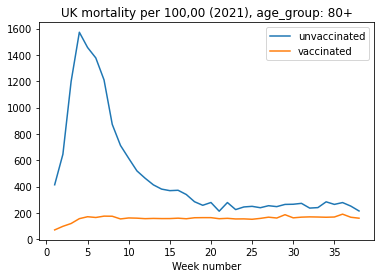

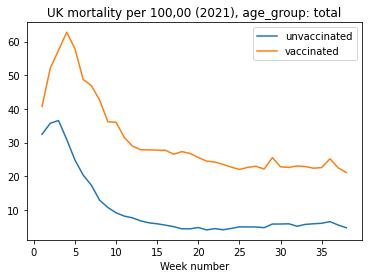

In [112]:
age_groups = ['10-59', '60-69', '70-79', '80+', 'total']
for age_group in age_groups:
    mean_diff = df_mortality.xs(key=age_group, level=1, axis=1)['unvaccinated'].div(df_mortality.xs(key=age_group, level=1, axis=1)['vaccinated']).mean()
    mean_diff_lasthalf = df_mortality.xs(key=age_group, level=1, axis=1)['unvaccinated'].div(df_mortality.xs(key=age_group, level=1, axis=1)['vaccinated']).tail(25).mean()
    print('age_group: %s  mean_diff:%.2f  mean_diff_last.half.year:%.2f' %(age_group, mean_diff, mean_diff_lasthalf))
    df_mortality.xs(key=age_group, level=1, axis=1).plot(title='UK mortality per 100,00 (2021), age_group: %s' %(age_group))

In [124]:
df_unvacc.tail(5)

Number of deaths                     Population            \
Age group              10-59 60-69  70-79    80+      10-59     60-69   
Week number                                                             
34.0                   105.0  69.0  100.0  198.0  7542599.0  272682.0   
35.0                   106.0  76.0  110.0  184.0  7404803.0  272148.0   
36.0                   100.0  90.0  125.0  193.0  7312771.0  271550.0   
37.0                    92.0  73.0   87.0  174.0  7241928.0  270878.0   
38.0                    68.0  65.0   78.0  148.0  7167322.0  270362.0   

                               Number of deaths Population  
Age group       70-79      80+            total      total  
Week number                                                 
34.0         131503.0  69745.0            472.0  8016529.0  
35.0         131334.0  69573.0            476.0  7877858.0  
36.0         131158.0  69366.0            508.0  7784845.0  
37.0         130991.0  69200.0            426.0  7712997.0  
38.0         130806.0  69021.0            359.0  7637511.0

In [125]:
df_vacc.tail(5)

Number of deaths                         Population             \
Age group              10-59  60-69   70-79     80+       10-59      60-69   
Week number                                                                  
34.0                   417.0  719.0  1745.0  4100.0  19485282.0  5022741.0   
35.0                   447.0  771.0  1703.0  4146.0  19611076.0  5025513.0   
36.0                   521.0  762.0  1946.0  4682.0  19691331.0  5028005.0   
37.0                   435.0  787.0  1746.0  4107.0  19749740.0  5030981.0   
38.0                   438.0  684.0  1599.0  3932.0  19811645.0  5033752.0   

                                  Number of deaths  Population  
Age group        70-79        80+            total       total  
Week number                                                     
34.0         4197535.0  2458394.0           6981.0  31163952.0  
35.0         4198841.0  2459740.0           7067.0  31295170.0  
36.0         4200251.0  2461053.0           7911.0  31380640.0  
37.0         4201338.0  2462010.0           7075.0  31444069.0  
38.0         4202835.0  2463822.0           6653.0  31512054.0